In [77]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

Creating a toy multi-class dataset

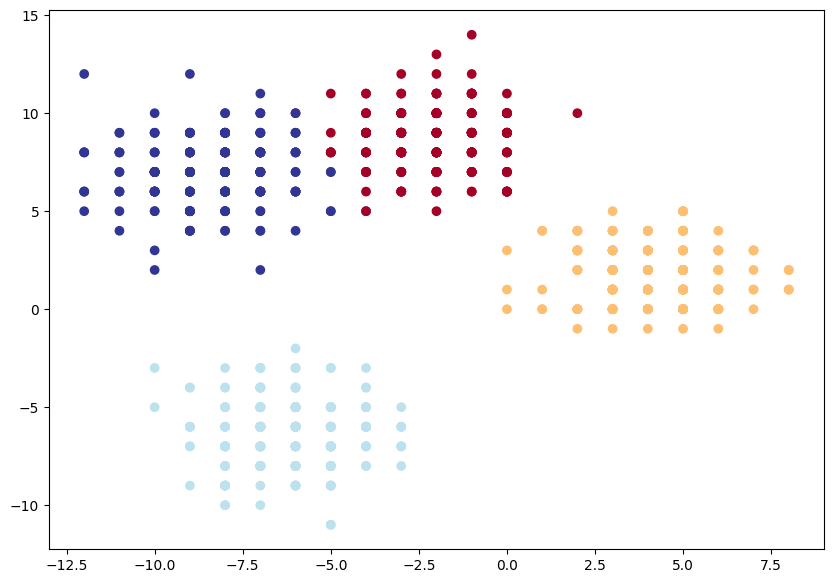

In [78]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-clas data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)

# Turn data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.LongTensor)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state= RANDOM_SEED
                                                                        )

plt.figure(figsize = (10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob , cmap=plt.cm.RdYlBu)

Creating a multi-class classfication model

In [79]:
# Create device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [80]:
# Build a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    """Initlializes multi-class classification model.

    Args:
      Input features(int): Number of input features to the model
      Output features(int): Number of outputs features
      Hidden_units(int): Number of hidden units between layers (default = 8)

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features= input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model_1 = BlobModel(input_features = 2,
                    output_features = 4,
                    hidden_units = 8).to(device)

In [81]:
model_1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [82]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [83]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [84]:
from torch.nn.modules.loss import CrossEntropyLoss
# Setup loss and optimizer

loss_fn = CrossEntropyLoss()
#Assigning a weight is particularly useful when you have an unbalanced trainin' set

optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

### Getting prediciton probabilities for a multi-class PyTorch model

In [85]:

#Let's get some raw outputs of our model(logits)
with torch.inference_mode():
  y_logits = model_1(X_blob_test.to(torch.float).to(device))
y_logits[:10]

tensor([[-1.0588, -0.7504, -1.2546, -0.4599],
        [ 1.5273, -1.1011,  1.5460,  1.8558],
        [ 2.1158,  0.6580,  2.4487,  0.9976],
        [-0.6193, -0.3535, -0.7127, -0.4101],
        [-0.4572, -1.5884, -0.7122,  0.6486],
        [ 1.9566, -1.2506,  1.9978,  2.3090],
        [ 1.6865,  0.8075,  1.9969,  0.5444],
        [ 0.1006, -1.4684, -0.0799,  1.0007],
        [ 2.8562,  0.6359,  3.2617,  1.6016],
        [-0.1462, -1.4610, -0.3509,  0.7994]], device='cuda:0')

In [86]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

#### In order to avluate and trand and test our model, we need to convert our model's outputs to prediction probabilites and then to prediction labels

Logits -> Pred Probs -> Pred labels

In [87]:
torch.argmax(torch.softmax(y_logits,dim=1)[0])

tensor(3, device='cuda:0')

In [88]:
torch.sum(torch.softmax(y_logits,dim=1)[0])

tensor(1., device='cuda:0')

In [89]:
# Convert our model's prediction probabilities to prediction labels
y_pred_probs = torch.softmax(y_logits, dim =1)
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([3, 3, 2, 1, 3], device='cuda:0')

In [90]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

Logits (raw output of the model) -> Pred probs (use "torch.softmax") -> Pred labels (Take the argmax of the prediction probabilities)

# Creating a training loop and testing loop for a multi-class PyTorch model

In [91]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [93]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_blob_train.to(torch.float))
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train, y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_blob_test.to(torch.float))
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits , y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss:4f}, Acc: {acc:.2f}%, Test loss: {test_loss:.4f}")




Epoch 0, Loss: 0.626020, Acc: 96.00%, Test loss: 0.4648
Epoch 10, Loss: 0.144498, Acc: 99.25%, Test loss: 0.1289
Epoch 20, Loss: 0.084339, Acc: 99.25%, Test loss: 0.0747
Epoch 30, Loss: 0.062934, Acc: 99.25%, Test loss: 0.0545
Epoch 40, Loss: 0.052304, Acc: 99.25%, Test loss: 0.0442
Epoch 50, Loss: 0.046037, Acc: 99.25%, Test loss: 0.0381
Epoch 60, Loss: 0.041940, Acc: 99.25%, Test loss: 0.0340
Epoch 70, Loss: 0.039068, Acc: 99.38%, Test loss: 0.0311
Epoch 80, Loss: 0.036953, Acc: 99.38%, Test loss: 0.0289
Epoch 90, Loss: 0.035336, Acc: 99.38%, Test loss: 0.0271
Epoch 100, Loss: 0.034063, Acc: 99.38%, Test loss: 0.0257
Epoch 110, Loss: 0.033038, Acc: 99.38%, Test loss: 0.0246
Epoch 120, Loss: 0.032196, Acc: 99.38%, Test loss: 0.0236
Epoch 130, Loss: 0.031493, Acc: 99.38%, Test loss: 0.0228
Epoch 140, Loss: 0.030898, Acc: 99.38%, Test loss: 0.0221
Epoch 150, Loss: 0.030387, Acc: 99.38%, Test loss: 0.0214
Epoch 160, Loss: 0.029946, Acc: 99.38%, Test loss: 0.0209
Epoch 170, Loss: 0.029559

In [94]:

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("Already exists!")
else:
  print("Downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

import helper_functions as hf

Downloading


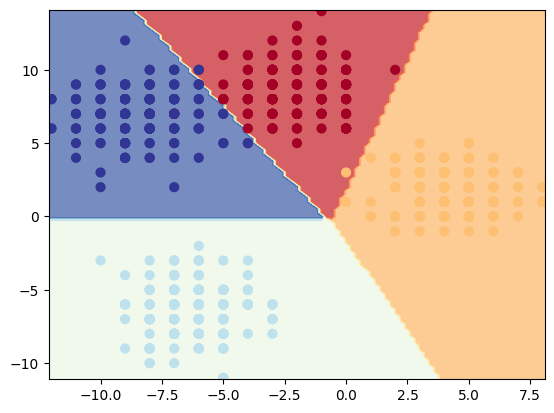

In [95]:
hf.plot_decision_boundary(model_1, X_blob_train, y_blob_train)

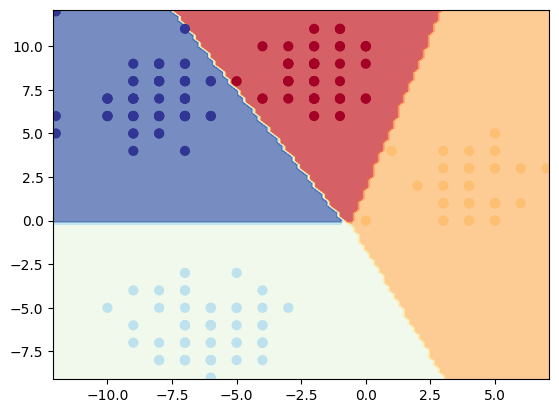

In [96]:
hf.plot_decision_boundary(model_1, X_blob_test, y_blob_test)

We don't prefer to use non-linearity functions just because our dataset is seperable as linear

#A few more classification metrics

* Accuracy
* Precision
* Recall
* Confusion Matrix
* F1-Score
* Classification Report

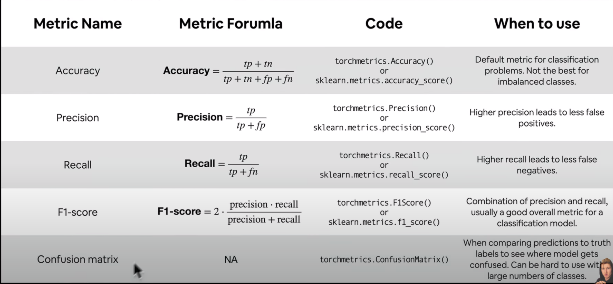